# **Lab 4: Algorithms and Resource Allocation**
# RPAD 676: Data Science for the Public Good
## Author: Leanna Zilles
## Date: 3/6/25

## Algorithm 1: Optimal Resource Allocation

In [ ]:
import numpy as np #mathematical operations library
import matplotlib.pyplot as plt #data visualization library

def optimal_resource_allocation(resources, needs, distances, max_distance=None):
    """
    Allocate limited resources to locations based on need and accessibility.

    Args:
        resources: Total resources available to distribute
        needs: Array of needs per location (higher = more needed)
        distances: Matrix of distances between locations
        max_distance: Maximum service distance (optional)

    Returns:
        allocations: Array of allocated resources per location
    """
    print("Starting resource allocation algorithm...")
    n_locations = len(needs)

    # Normalize needs to sum to 1
    normalized_needs = needs / np.sum(needs)
    print(f"Normalized needs: min={normalized_needs.min():.4f}, max={normalized_needs.max():.4f}")

    # Calculate accessibility scores
    if max_distance is None:
        max_distance = np.median(distances)
        print(f"Using median distance ({max_distance:.2f}) as max_distance parameter")

    accessibility = np.zeros(n_locations)
    for i in range(n_locations):
        # Create a copy of the distances to avoid modifying the original
        dist_i = distances[i].copy()
        # Set self-distance to a very large number instead of infinity
        dist_i[i] = 9999999  # This avoids the infinity issue
        weight = np.exp(-dist_i / max_distance)
        accessibility[i] = np.sum(weight)

    # Normalize accessibility
    accessibility = accessibility / np.sum(accessibility)
    print(f"Accessibility scores: min={accessibility.min():.4f}, max={accessibility.max():.4f}")

    # Combine needs and accessibility (70% needs, 30% accessibility)
    combined_score = 0.7 * normalized_needs + 0.3 * accessibility
    combined_score = combined_score / np.sum(combined_score)

    # Allocate resources
    allocations = resources * combined_score

    # Round to integers
    allocations = np.round(allocations).astype(int)
    print(f"Initial allocation: {np.sum(allocations)} of {resources} resources")

    # Adjust for rounding errors
    diff = resources - np.sum(allocations)
    if diff > 0:
        # Allocate remaining resources to highest-need locations
        indices = np.argsort(normalized_needs)[::-1]
        for i in range(diff):
            allocations[indices[i % n_locations]] += 1
        print(f"Added {diff} remaining resources to highest-need locations")
    elif diff < 0:
        # Remove from lowest-need locations
        indices = np.argsort(normalized_needs)
        for i in range(abs(diff)):
            if allocations[indices[i % n_locations]] > 0:
                allocations[indices[i % n_locations]] -= 1
        print(f"Removed {abs(diff)} excess resources from lowest-need locations")

    print("Resource allocation complete")
    return allocations



In [ ]:
# Create test data for resource allocation
def create_allocation_example():
    print("Creating test data for resource allocation...")
    # Create 5 locations with varying needs
    n_locations = 5

    # Population at each location
    population = np.array([5000, 8000, 3000, 12000, 7000])

    # Need score (e.g., poverty rate from 0-1)
    need_scores = np.array([0.3, 0.5, 0.2, 0.7, 0.4])

    # Distance matrix between locations (in miles)
    distances = np.array([
        [0, 10, 15, 25, 20],  # Distances from location 0 to all others
        [10, 0, 12, 18, 15],  # Distances from location 1 to all others
        [15, 12, 0, 30, 10],  # Distances from location 2 to all others
        [25, 18, 30, 0, 12],  # Distances from location 3 to all others
        [20, 15, 10, 12, 0]   # Distances from location 4 to all others
    ])

    # Total resources to allocate (e.g., $10 million in community development funds)
    total_resources = 100

    print(f"Created data for {n_locations} locations with ${total_resources} to allocate")
    return population, need_scores, distances, total_resources



Creating test data for resource allocation...
Created data for 5 locations with $100 to allocate
Starting resource allocation algorithm...
Normalized needs: min=0.0952, max=0.3333
Using median distance (12.00) as max_distance parameter
Accessibility scores: min=0.1426, max=0.2346
Initial allocation: 101 of 100 resources
Removed 1 excess resources from lowest-need locations
Resource allocation complete


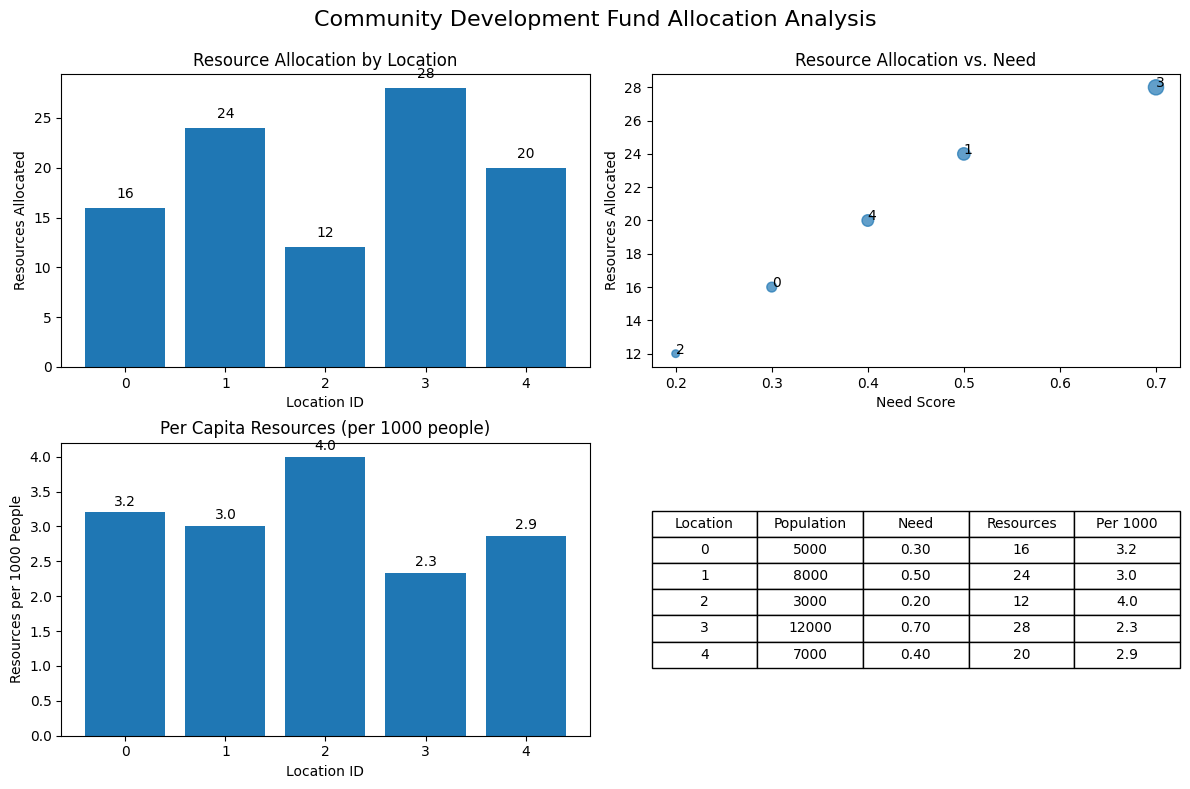


Allocation Summary:
Total Resources Allocated: 100
Correlation with Need Score: 0.9864
Per Capita Range: 2.33 to 4.00


In [ ]:
# Run the algorithm and visualize results
def run_allocation_example():
    # Get data
    population, need_scores, distances, total_resources = create_allocation_example()

    # Run allocation algorithm
    allocations = optimal_resource_allocation(total_resources, need_scores, distances)

    # Calculate per capita allocation for analysis
    per_capita = allocations / population * 1000  # Resources per 1000 people

    # Visualize results
    plt.figure(figsize=(12, 8))

    # Plot 1: Allocation by location
    plt.subplot(2, 2, 1)
    plt.bar(range(len(allocations)), allocations)
    plt.title('Resource Allocation by Location')
    plt.xlabel('Location ID')
    plt.ylabel('Resources Allocated')
    plt.xticks(range(len(allocations)))
    for i, v in enumerate(allocations):
        plt.text(i, v+1, str(v), ha='center')

    # Plot 2: Resources vs Need
    plt.subplot(2, 2, 2)
    plt.scatter(need_scores, allocations, s=population/100, alpha=0.7)
    plt.title('Resource Allocation vs. Need')
    plt.xlabel('Need Score')
    plt.ylabel('Resources Allocated')
    for i, txt in enumerate(range(len(allocations))):
        plt.annotate(txt, (need_scores[i], allocations[i]))

    # Plot 3: Per capita resources
    plt.subplot(2, 2, 3)
    plt.bar(range(len(per_capita)), per_capita)
    plt.title('Per Capita Resources (per 1000 people)')
    plt.xlabel('Location ID')
    plt.ylabel('Resources per 1000 People')
    plt.xticks(range(len(per_capita)))
    for i, v in enumerate(per_capita):
        plt.text(i, v+0.1, f"{v:.1f}", ha='center')

    # Plot 4: Table of values
    plt.subplot(2, 2, 4)
    plt.axis('off')
    table_data = [
        ["Location", "Population", "Need", "Resources", "Per 1000"],
    ]
    for i in range(len(allocations)):
        table_data.append([
            f"{i}",
            f"{population[i]}",
            f"{need_scores[i]:.2f}",
            f"{allocations[i]}",
            f"{per_capita[i]:.1f}"
        ])
    table = plt.table(cellText=table_data, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.tight_layout()
    plt.suptitle('Community Development Fund Allocation Analysis', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

    # Print summary statistics
    print("\nAllocation Summary:")
    print(f"Total Resources Allocated: {np.sum(allocations)}")
    print(f"Correlation with Need Score: {np.corrcoef(need_scores, allocations)[0,1]:.4f}")
    print(f"Per Capita Range: {np.min(per_capita):.2f} to {np.max(per_capita):.2f}")

    return allocations, population, need_scores

# Run the example
if __name__ == "__main__":
    allocations, population, need_scores = run_allocation_example()

## Algorithm 2: Service Center Location Optimization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def clustering_based_service_locations(coordinates, num_centers, population_weights=None):
    """
    Find optimal service center locations using weighted k-means clustering.

    Args:
        coordinates: Array of coordinates for population points
        num_centers: Number of service centers to place
        population_weights: Weights for each coordinate

    Returns:
        center_locations: Coordinates of the recommended service centers
        assignments: Assigned center for each input coordinate
    """
    print("Starting service location clustering algorithm...")
    n_points = coordinates.shape[0]

    # If no weights provided, use equal weights
    if population_weights is None:
        print("No population weights provided. Using equal weights.")
        population_weights = np.ones(n_points)
    else:
        print(f"Using population weights (min={min(population_weights):.1f}, max={max(population_weights):.1f})")

    # Normalize weights
    weights = population_weights / np.sum(population_weights)

    # Initialize centers randomly
    np.random.seed(42)  # For reproducibility
    idx = np.random.choice(n_points, num_centers, replace=False)
    centers = coordinates[idx].copy()
    print(f"Initialized {num_centers} random center locations")

    # K-means iterations
    max_iterations = 100
    tolerance = 1e-4

    for iteration in range(max_iterations):
        # Calculate distances to centers
        distances = np.zeros((n_points, num_centers))
        for i in range(num_centers):
            distances[:, i] = np.sum((coordinates - centers[i])**2, axis=1)

        # Assign points to nearest center
        assignments = np.argmin(distances, axis=1)

        # Update centers
        new_centers = np.zeros_like(centers)
        for i in range(num_centers):
            mask = (assignments == i)
            if np.sum(mask) > 0:
                # Weighted average of points
                new_centers[i] = np.average(
                    coordinates[mask],
                    axis=0,
                    weights=weights[mask]
                )

        # Check convergence
        center_shift = np.sum((centers - new_centers)**2)
        centers = new_centers

        if center_shift < tolerance:
            print(f"Converged after {iteration+1} iterations")
            break

    print("Service center location optimization complete")
    return centers, assignments



In [ ]:
# Create test data for service center placement
def create_clustering_example():
    print("Creating test data for service center placement...")
    # Set random seed for reproducibility
    np.random.seed(42)

    # Create three clusters of population points
    n_points = 100

    # Cluster 1: Dense urban area
    urban_x = np.random.normal(25, 5, size=50)
    urban_y = np.random.normal(25, 5, size=50)
    urban_pop = np.random.normal(1000, 200, size=50)  # Higher population

    # Cluster 2: Suburban area
    suburban_x = np.random.normal(75, 10, size=30)
    suburban_y = np.random.normal(50, 10, size=30)
    suburban_pop = np.random.normal(500, 100, size=30)  # Medium population

    # Cluster 3: Rural area
    rural_x = np.random.normal(40, 15, size=20)
    rural_y = np.random.normal(75, 15, size=20)
    rural_pop = np.random.normal(200, 50, size=20)  # Lower population

    # Combine into single arrays
    x_coords = np.concatenate([urban_x, suburban_x, rural_x])
    y_coords = np.concatenate([urban_y, suburban_y, rural_y])
    population = np.concatenate([urban_pop, suburban_pop, rural_pop])

    # Create coordinates array
    coordinates = np.column_stack([x_coords, y_coords])

    # Number of service centers to place
    num_centers = 5

    print(f"Created {len(coordinates)} population points and will place {num_centers} centers")
    return coordinates, population, num_centers



Creating test data for service center placement...
Created 100 population points and will place 5 centers
Starting service location clustering algorithm...
Using population weights (min=102.4, max=1492.6)
Initialized 5 random center locations
Converged after 8 iterations
Service center location optimization complete

Service Center Statistics:
Center | Population Served | # of Locations | Avg Distance
-------|-------------------|----------------|-------------
      0 |              3324 |               16 |       16.40
      1 |              6606 |               15 |       11.38
      2 |              9098 |               18 |        9.70
      3 |             19000 |               20 |        5.05
      4 |             30886 |               31 |        4.70


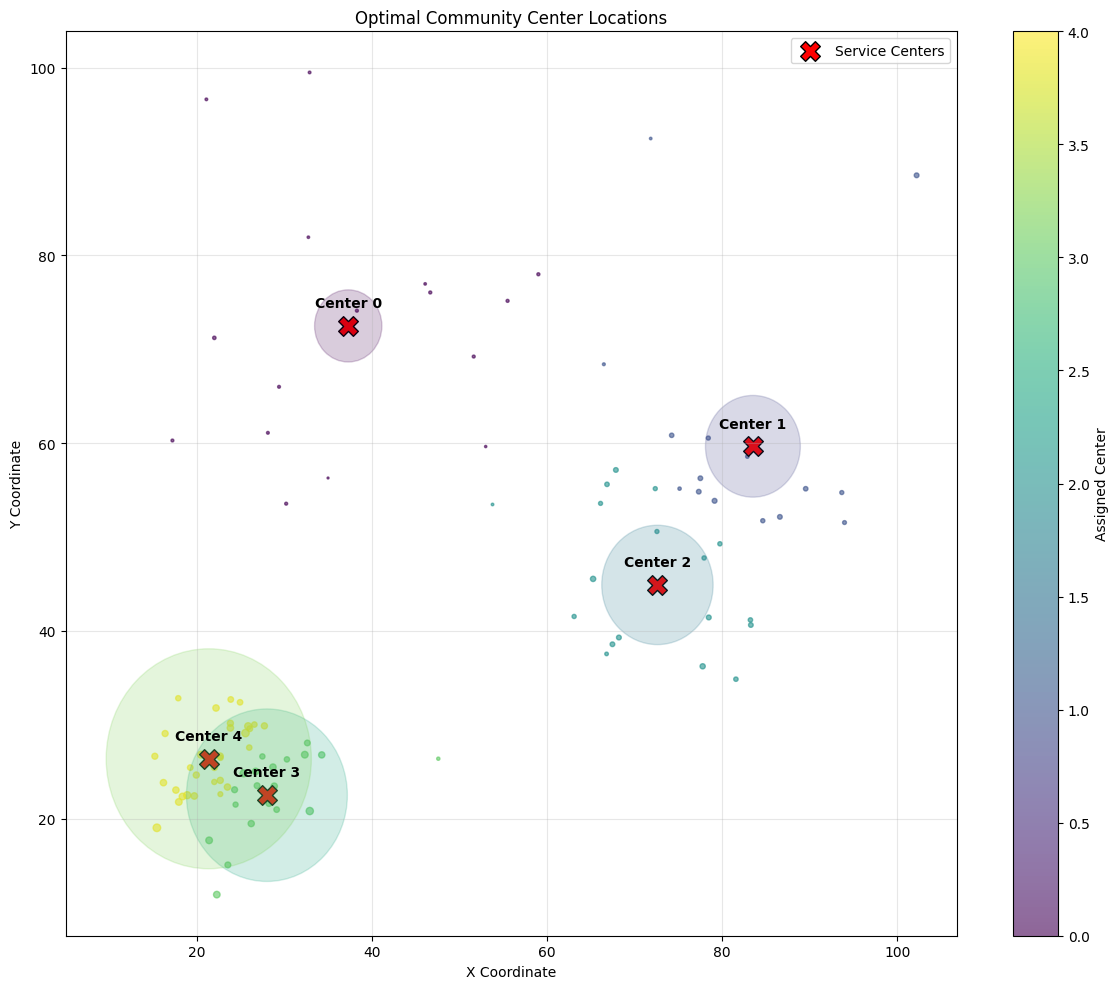

In [ ]:
# Run the algorithm and visualize results
def run_clustering_example():
    # Get data
    coordinates, population, num_centers = create_clustering_example()

    # Run clustering algorithm
    centers, assignments = clustering_based_service_locations(coordinates, num_centers, population)

    # Visualize the results
    plt.figure(figsize=(12, 10))

    # Plot population points, sized by population and colored by assigned center
    scatter = plt.scatter(
        coordinates[:, 0], coordinates[:, 1],
        s=population/50,  # Size by population
        c=assignments,    # Color by assignment
        cmap='viridis',
        alpha=0.6
    )

    # Plot service centers
    plt.scatter(
        centers[:, 0], centers[:, 1],
        s=200,
        c='red',
        marker='X',
        edgecolors='black',
        label='Service Centers'
    )

    # Add center labels
    for i, (x, y) in enumerate(centers):
        plt.text(x, y+2, f'Center {i}', ha='center', fontweight='bold')

    # Add a visual representation of population served
    for i in range(num_centers):
        mask = (assignments == i)
        pop_served = np.sum(population[mask])
        # Draw a circle proportional to population served
        pop_radius = np.sqrt(pop_served) / 15
        circle = plt.Circle(
            (centers[i, 0], centers[i, 1]),
            pop_radius,
            color=plt.cm.viridis(i/num_centers),
            alpha=0.2
        )
        plt.gca().add_patch(circle)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Optimal Community Center Locations')
    plt.grid(True, alpha=0.3)
    plt.colorbar(scatter, label='Assigned Center')
    plt.legend()

    # Print statistics for each center
    print("\nService Center Statistics:")
    print("Center | Population Served | # of Locations | Avg Distance")
    print("-------|-------------------|----------------|-------------")

    for i in range(num_centers):
        mask = (assignments == i)
        locations_served = np.sum(mask)
        pop_served = np.sum(population[mask])

        # Calculate average distance to center
        if locations_served > 0:
            center_dists = np.sqrt(np.sum((coordinates[mask] - centers[i])**2, axis=1))
            avg_dist = np.average(center_dists, weights=population[mask])
        else:
            avg_dist = 0

        print(f"{i:7d} | {pop_served:17.0f} | {locations_served:16d} | {avg_dist:11.2f}")

    plt.tight_layout()
    plt.show()

    return centers, assignments, coordinates, population

# Run the example
if __name__ == "__main__":
    centers, assignments, coordinates, population = run_clustering_example()

## Algorithm 3: Equity-Adjusted Program Access

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def equity_adjusted_scoring(scores, demographic_groups, adjustment_factor=0.1):
    """
    Adjust scores to reduce demographic disparities while maintaining ranking integrity.

    Args:
        scores: Original merit-based scores (higher is better)
        demographic_groups: Group indicator for each score (categorical)
        adjustment_factor: Strength of the adjustment (0 = no change, 1 = full equalization)

    Returns:
        adjusted_scores: Scores adjusted to reduce demographic disparities
        group_means: Mean scores by group before and after adjustment
    """
    print("Starting equity adjustment algorithm...")
    print(f"Adjustment factor: {adjustment_factor}")

    # Calculate global mean
    global_mean = np.mean(scores)
    print(f"Global mean score: {global_mean:.2f}")

    # Calculate group means
    unique_groups = np.unique(demographic_groups)
    group_means = {}

    print("Original group statistics:")
    for group in unique_groups:
        mask = (demographic_groups == group)
        group_mean = np.mean(scores[mask])
        group_count = np.sum(mask)
        group_means[group] = {
            'original_mean': group_mean,
            'count': group_count
        }
        print(f"  Group {group}: mean={group_mean:.2f}, count={group_count}")

    # Calculate adjustments
    print("Calculating adjustments...")
    adjustments = np.zeros_like(scores)
    for group in unique_groups:
        mask = (demographic_groups == group)
        group_diff = global_mean - group_means[group]['original_mean']
        adjustments[mask] = group_diff * adjustment_factor
        print(f"  Group {group}: adjustment={group_diff * adjustment_factor:.2f}")

    # Apply adjustments
    adjusted_scores = scores + adjustments

    # Calculate new group means
    print("Adjusted group statistics:")
    for group in unique_groups:
        mask = (demographic_groups == group)
        adjusted_mean = np.mean(adjusted_scores[mask])
        group_means[group]['adjusted_mean'] = adjusted_mean
        print(f"  Group {group}: adjusted mean={adjusted_mean:.2f}")

    # Calculate disparity reduction
    original_disparity = max([group_means[g]['original_mean'] for g in unique_groups]) - \
                        min([group_means[g]['original_mean'] for g in unique_groups])

    adjusted_disparity = max([group_means[g]['adjusted_mean'] for g in unique_groups]) - \
                        min([group_means[g]['adjusted_mean'] for g in unique_groups])

    disparity_reduction = (original_disparity - adjusted_disparity) / original_disparity * 100
    print(f"Disparity reduction: {disparity_reduction:.1f}%")

    print("Equity adjustment complete")
    return adjusted_scores, group_means



In [ ]:
# Create test data for equity adjustment
def create_equity_example():
    print("Creating test data for equity adjustment...")
    # Set random seed for reproducibility
    np.random.seed(42)

    # Create three demographic groups with different score distributions
    n_applicants = 300

    # Group A: Higher average scores
    group_a_scores = np.random.normal(80, 10, size=100)
    group_a_labels = np.array(['A'] * 100)

    # Group B: Medium average scores
    group_b_scores = np.random.normal(70, 10, size=100)
    group_b_labels = np.array(['B'] * 100)

    # Group C: Lower average scores
    group_c_scores = np.random.normal(60, 10, size=100)
    group_c_labels = np.array(['C'] * 100)

    # Combine into single arrays
    all_scores = np.concatenate([group_a_scores, group_b_scores, group_c_scores])
    all_groups = np.concatenate([group_a_labels, group_b_labels, group_c_labels])

    # Adjustment factor
    adjustment_factor = 0.5  # Start with medium adjustment

    print(f"Created {len(all_scores)} applicants from {len(np.unique(all_groups))} demographic groups")
    return all_scores, all_groups, adjustment_factor



Creating test data for equity adjustment...
Created 300 applicants from 3 demographic groups
Starting equity adjustment algorithm...
Adjustment factor: 0.5
Global mean score: 69.94
Original group statistics:
  Group A: mean=78.96, count=100
  Group B: mean=70.22, count=100
  Group C: mean=60.65, count=100
Calculating adjustments...
  Group A: adjustment=-4.51
  Group B: adjustment=-0.14
  Group C: adjustment=4.65
Adjusted group statistics:
  Group A: adjusted mean=74.45
  Group B: adjusted mean=70.08
  Group C: adjusted mean=65.30
Disparity reduction: 50.0%
Equity adjustment complete


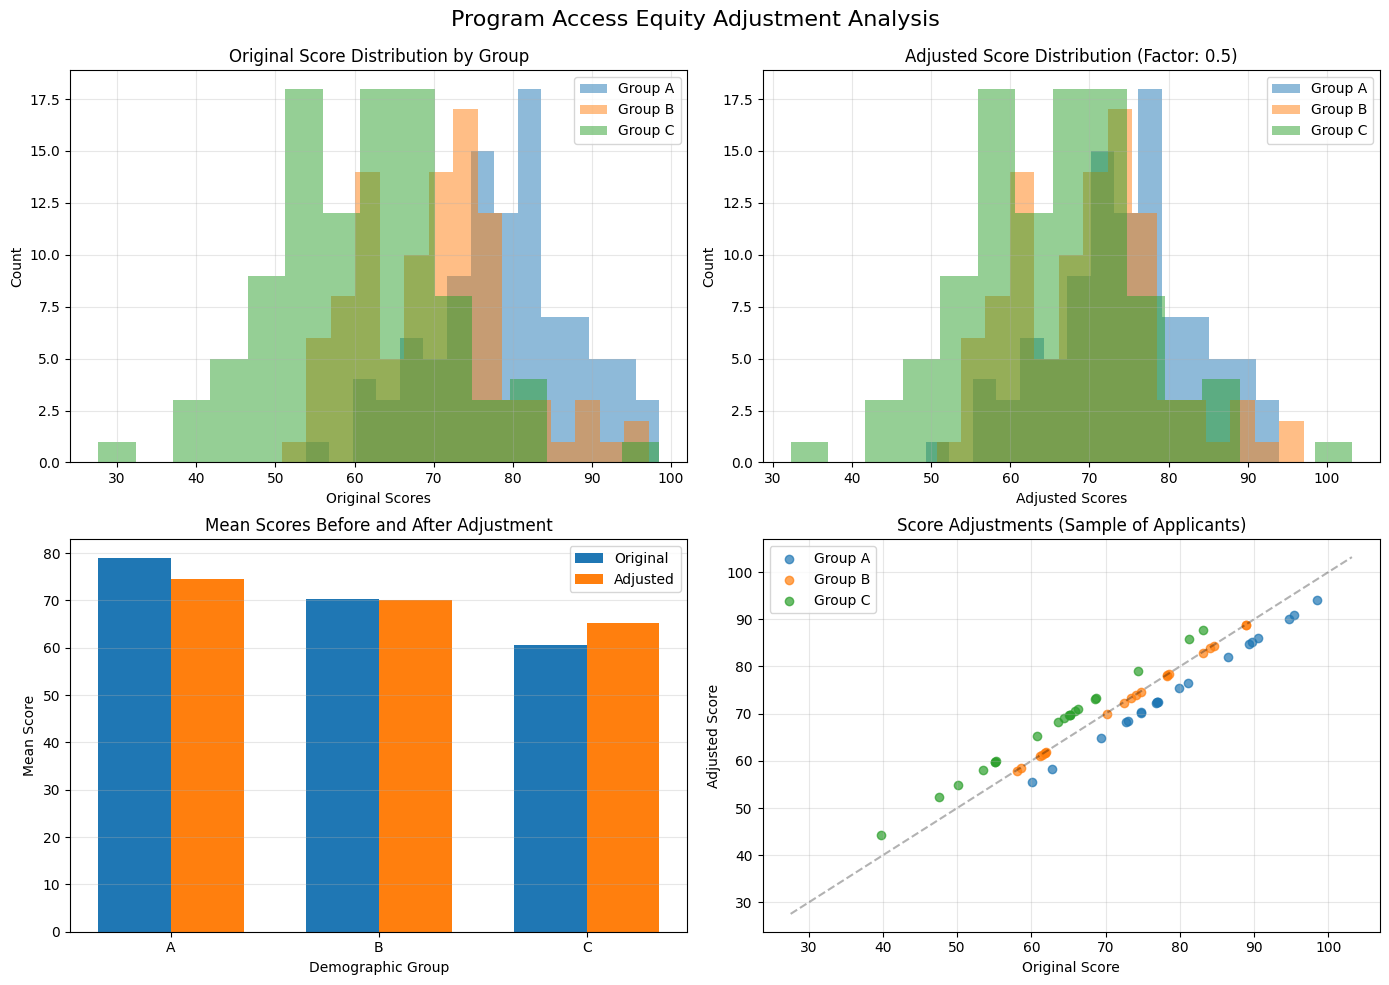


Program Access Analysis (Top 30% selected):
Original score threshold: 76.61
Adjusted score threshold: 74.83

Group representation in program:
Group | Original % | Adjusted % | Change
------|------------|------------|-------
A      |       62.0% |       48.0% |  -14.0%
B      |       22.0% |       26.0% |   +4.0%
C      |        6.0% |       16.0% |  +10.0%


In [ ]:
# Run the algorithm and visualize results
def run_equity_example():
    # Get data
    scores, demographic_groups, adjustment_factor = create_equity_example()

    # Run equity adjustment algorithm
    adjusted_scores, group_means = equity_adjusted_scoring(scores, demographic_groups, adjustment_factor)

    # Visualize the results
    plt.figure(figsize=(14, 10))

    # Plot 1: Original score distributions by group
    plt.subplot(2, 2, 1)
    groups = np.unique(demographic_groups)
    for group in groups:
        mask = (demographic_groups == group)
        plt.hist(scores[mask], alpha=0.5, bins=15, label=f'Group {group}')

    plt.xlabel('Original Scores')
    plt.ylabel('Count')
    plt.title('Original Score Distribution by Group')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Adjusted score distributions by group
    plt.subplot(2, 2, 2)
    for group in groups:
        mask = (demographic_groups == group)
        plt.hist(adjusted_scores[mask], alpha=0.5, bins=15, label=f'Group {group}')

    plt.xlabel('Adjusted Scores')
    plt.ylabel('Count')
    plt.title(f'Adjusted Score Distribution (Factor: {adjustment_factor})')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Group means before and after
    plt.subplot(2, 2, 3)
    group_list = list(groups)
    x = np.arange(len(group_list))
    width = 0.35

    original_means = [group_means[g]['original_mean'] for g in group_list]
    adjusted_means = [group_means[g]['adjusted_mean'] for g in group_list]

    plt.bar(x - width/2, original_means, width, label='Original')
    plt.bar(x + width/2, adjusted_means, width, label='Adjusted')

    plt.xlabel('Demographic Group')
    plt.ylabel('Mean Score')
    plt.title('Mean Scores Before and After Adjustment')
    plt.xticks(x, group_list)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # Plot 4: Score changes for a sample of applicants
    plt.subplot(2, 2, 4)

    # Select 20 random applicants from each group for clarity
    sampled_indices = []
    for group in groups:
        mask = (demographic_groups == group)
        indices = np.where(mask)[0]
        if len(indices) > 20:
            indices = np.random.choice(indices, 20, replace=False)
        sampled_indices.extend(indices)

    sampled_indices = np.array(sampled_indices)

    # Create scatter plot of original vs adjusted scores
    for group in groups:
        mask = (demographic_groups[sampled_indices] == group)
        plt.scatter(
            scores[sampled_indices][mask],
            adjusted_scores[sampled_indices][mask],
            alpha=0.7,
            label=f'Group {group}'
        )

    # Add the y=x line
    min_score = min(np.min(scores), np.min(adjusted_scores))
    max_score = max(np.max(scores), np.max(adjusted_scores))
    plt.plot([min_score, max_score], [min_score, max_score], 'k--', alpha=0.3)

    plt.xlabel('Original Score')
    plt.ylabel('Adjusted Score')
    plt.title('Score Adjustments (Sample of Applicants)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Program Access Equity Adjustment Analysis', fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

    # Calculate and print additional metrics
    threshold = np.percentile(scores, 70)  # Top 30% get into program
    adjusted_threshold = np.percentile(adjusted_scores, 70)

    print("\nProgram Access Analysis (Top 30% selected):")
    print(f"Original score threshold: {threshold:.2f}")
    print(f"Adjusted score threshold: {adjusted_threshold:.2f}")

    print("\nGroup representation in program:")
    print("Group | Original % | Adjusted % | Change")
    print("------|------------|------------|-------")

    for group in groups:
        mask = (demographic_groups == group)
        original_selected = np.sum((scores[mask] >= threshold)) / np.sum(mask) * 100
        adjusted_selected = np.sum((adjusted_scores[mask] >= adjusted_threshold)) / np.sum(mask) * 100
        change = adjusted_selected - original_selected

        print(f"{group:6s} | {original_selected:10.1f}% | {adjusted_selected:10.1f}% | {change:+6.1f}%")

    return adjusted_scores, scores, demographic_groups, group_means

# Run the example
if __name__ == "__main__":
    adjusted_scores, original_scores, groups, group_means = run_equity_example()

# Algorithm 1 with more weight on needs

In [2]:
import numpy as np #mathematical operations library
import matplotlib.pyplot as plt #data visualization library

def optimal_resource_allocation(resources, needs, distances, max_distance=None):
    """
    Allocate limited resources to locations based on need and accessibility.

    Args:
        resources: Total resources available to distribute
        needs: Array of needs per location (higher = more needed)
        distances: Matrix of distances between locations
        max_distance: Maximum service distance (optional)

    Returns:
        allocations: Array of allocated resources per location
    """
    print("Starting resource allocation algorithm...")
    n_locations = len(needs)

    # Normalize needs to sum to 1
    normalized_needs = needs / np.sum(needs)
    print(f"Normalized needs: min={normalized_needs.min():.4f}, max={normalized_needs.max():.4f}")

    # Calculate accessibility scores
    if max_distance is None:
        max_distance = np.median(distances)
        print(f"Using median distance ({max_distance:.2f}) as max_distance parameter")

    accessibility = np.zeros(n_locations)
    for i in range(n_locations):
        # Create a copy of the distances to avoid modifying the original
        dist_i = distances[i].copy()
        # Set self-distance to a very large number instead of infinity
        dist_i[i] = 9999999  # This avoids the infinity issue
        weight = np.exp(-dist_i / max_distance)
        accessibility[i] = np.sum(weight)

    # Normalize accessibility
    accessibility = accessibility / np.sum(accessibility)
    print(f"Accessibility scores: min={accessibility.min():.4f}, max={accessibility.max():.4f}")

    # Change needs and accessibility weights (80% needs, 20% accessibility)
    combined_score = 0.8 * normalized_needs + 0.2 * accessibility
    combined_score = combined_score / np.sum(combined_score)

    # Allocate resources
    allocations = resources * combined_score

    # Round to integers
    allocations = np.round(allocations).astype(int)
    print(f"Initial allocation: {np.sum(allocations)} of {resources} resources")

    # Adjust for rounding errors
    diff = resources - np.sum(allocations)
    if diff > 0:
        # Allocate remaining resources to highest-need locations
        indices = np.argsort(normalized_needs)[::-1]
        for i in range(diff):
            allocations[indices[i % n_locations]] += 1
        print(f"Added {diff} remaining resources to highest-need locations")
    elif diff < 0:
        # Remove from lowest-need locations
        indices = np.argsort(normalized_needs)
        for i in range(abs(diff)):
            if allocations[indices[i % n_locations]] > 0:
                allocations[indices[i % n_locations]] -= 1
        print(f"Removed {abs(diff)} excess resources from lowest-need locations")

    print("Resource allocation complete")
    return allocations

In [3]:
# Create test data for resource allocation
def create_allocation_example():
    print("Creating test data for resource allocation...")
    # Create 5 locations with varying needs
    n_locations = 5

    # Population at each location
    population = np.array([5000, 8000, 3000, 12000, 7000])

    # Need score (e.g., poverty rate from 0-1)
    need_scores = np.array([0.3, 0.5, 0.2, 0.7, 0.4])

    # Distance matrix between locations (in miles)
    distances = np.array([
        [0, 10, 15, 25, 20],  # Distances from location 0 to all others
        [10, 0, 12, 18, 15],  # Distances from location 1 to all others
        [15, 12, 0, 30, 10],  # Distances from location 2 to all others
        [25, 18, 30, 0, 12],  # Distances from location 3 to all others
        [20, 15, 10, 12, 0]   # Distances from location 4 to all others
    ])

    # Total resources to allocate (e.g., $10 million in community development funds)
    total_resources = 100

    print(f"Created data for {n_locations} locations with ${total_resources} to allocate")
    return population, need_scores, distances, total_resources

Creating test data for resource allocation...
Created data for 5 locations with $100 to allocate
Starting resource allocation algorithm...
Normalized needs: min=0.0952, max=0.3333
Using median distance (12.00) as max_distance parameter
Accessibility scores: min=0.1426, max=0.2346
Initial allocation: 101 of 100 resources
Removed 1 excess resources from lowest-need locations
Resource allocation complete


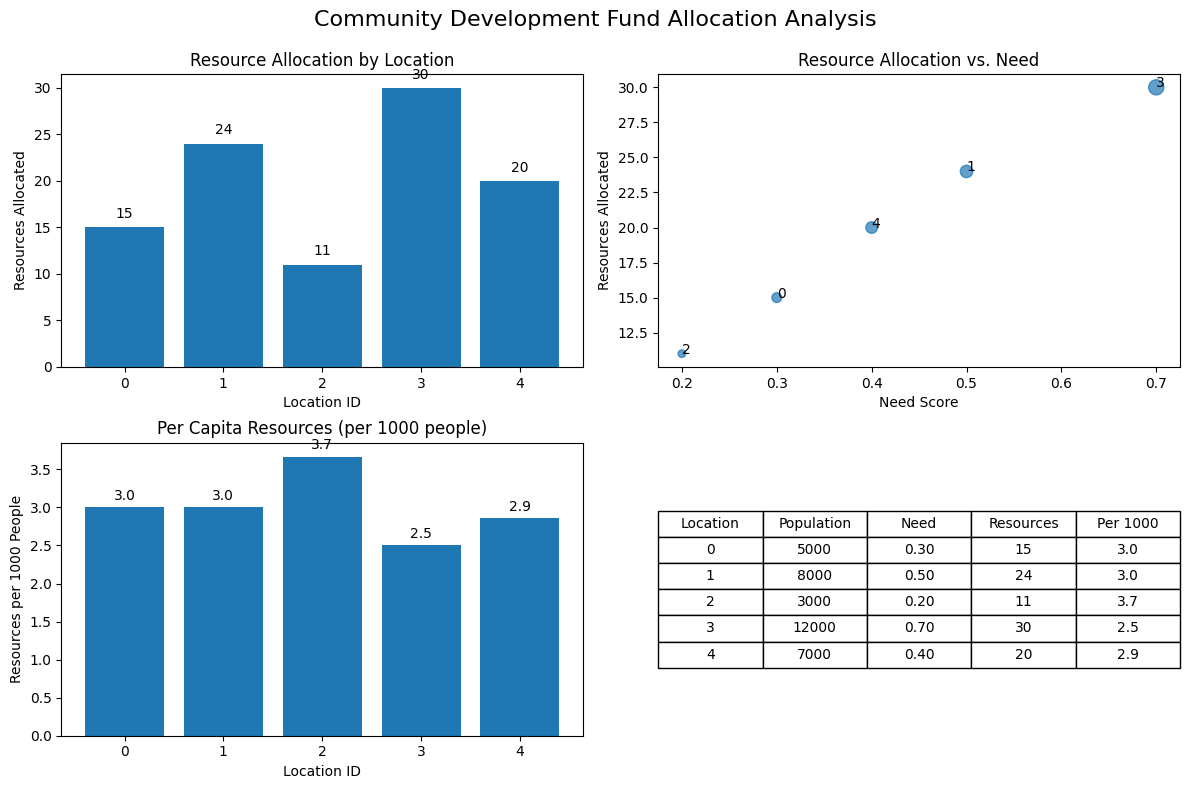


Allocation Summary:
Total Resources Allocated: 100
Correlation with Need Score: 0.9944
Per Capita Range: 2.50 to 3.67


In [4]:
# Run the algorithm and visualize results
def run_allocation_example():
    # Get data
    population, need_scores, distances, total_resources = create_allocation_example()

    # Run allocation algorithm
    allocations = optimal_resource_allocation(total_resources, need_scores, distances)

    # Calculate per capita allocation for analysis
    per_capita = allocations / population * 1000  # Resources per 1000 people

    # Visualize results
    plt.figure(figsize=(12, 8))

    # Plot 1: Allocation by location
    plt.subplot(2, 2, 1)
    plt.bar(range(len(allocations)), allocations)
    plt.title('Resource Allocation by Location')
    plt.xlabel('Location ID')
    plt.ylabel('Resources Allocated')
    plt.xticks(range(len(allocations)))
    for i, v in enumerate(allocations):
        plt.text(i, v+1, str(v), ha='center')

    # Plot 2: Resources vs Need
    plt.subplot(2, 2, 2)
    plt.scatter(need_scores, allocations, s=population/100, alpha=0.7)
    plt.title('Resource Allocation vs. Need')
    plt.xlabel('Need Score')
    plt.ylabel('Resources Allocated')
    for i, txt in enumerate(range(len(allocations))):
        plt.annotate(txt, (need_scores[i], allocations[i]))

    # Plot 3: Per capita resources
    plt.subplot(2, 2, 3)
    plt.bar(range(len(per_capita)), per_capita)
    plt.title('Per Capita Resources (per 1000 people)')
    plt.xlabel('Location ID')
    plt.ylabel('Resources per 1000 People')
    plt.xticks(range(len(per_capita)))
    for i, v in enumerate(per_capita):
        plt.text(i, v+0.1, f"{v:.1f}", ha='center')

    # Plot 4: Table of values
    plt.subplot(2, 2, 4)
    plt.axis('off')
    table_data = [
        ["Location", "Population", "Need", "Resources", "Per 1000"],
    ]
    for i in range(len(allocations)):
        table_data.append([
            f"{i}",
            f"{population[i]}",
            f"{need_scores[i]:.2f}",
            f"{allocations[i]}",
            f"{per_capita[i]:.1f}"
        ])
    table = plt.table(cellText=table_data, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.tight_layout()
    plt.suptitle('Community Development Fund Allocation Analysis', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

    # Print summary statistics
    print("\nAllocation Summary:")
    print(f"Total Resources Allocated: {np.sum(allocations)}")
    print(f"Correlation with Need Score: {np.corrcoef(need_scores, allocations)[0,1]:.4f}")
    print(f"Per Capita Range: {np.min(per_capita):.2f} to {np.max(per_capita):.2f}")

    return allocations, population, need_scores

# Run the example
if __name__ == "__main__":
    allocations, population, need_scores = run_allocation_example()

# Reflection Question 1

**1:** The results suggest that the county should allocate resources to where there is the most need. Levels of need correlate directly with population size.

The results also suggest that the county should establish service centers in either centrally located areas where they can serve the highest number of people, or in areas where people in remote locations could still feasibly access them.

The adjusted score distribution shows whether score modifications are enough to ensure that groups can be more equitably represented in the program. The results imply that the system proposed algorithm 3, in which programs admit individuals with the top 30% of scores while adjusting scores upward to account for groups that appear to experience systemic disadvantages in admission, equalizes opportunity to some degree.

In [9]:
import numpy as np #mathematical operations library
import matplotlib.pyplot as plt #data visualization library

def optimal_resource_allocation(resources, needs, distances, max_distance=None):
    """
    Allocate limited resources to locations based on need and accessibility.

    Args:
        resources: Total resources available to distribute
        needs: Array of needs per location (higher = more needed)
        distances: Matrix of distances between locations
        max_distance: Maximum service distance (optional)

    Returns:
        allocations: Array of allocated resources per location
    """
    print("Starting resource allocation algorithm...")
    n_locations = len(needs)

    # Normalize needs to sum to 1
    normalized_needs = needs / np.sum(needs)
    print(f"Normalized needs: min={normalized_needs.min():.4f}, max={normalized_needs.max():.4f}")

    # Calculate accessibility scores
    if max_distance is None:
        max_distance = np.median(distances)
        print(f"Using median distance ({max_distance:.2f}) as max_distance parameter")

    accessibility = np.zeros(n_locations)
    for i in range(n_locations):
        # Create a copy of the distances to avoid modifying the original
        dist_i = distances[i].copy()
        # Set self-distance to a very large number instead of infinity
        dist_i[i] = 9999999  # This avoids the infinity issue
        weight = np.exp(-dist_i / max_distance)
        accessibility[i] = np.sum(weight)

    # Normalize accessibility
    accessibility = accessibility / np.sum(accessibility)
    print(f"Accessibility scores: min={accessibility.min():.4f}, max={accessibility.max():.4f}")

    # Change needs and accessibility weights (60% needs, 40% accessibility)
    combined_score = 0.6 * normalized_needs + 0.4 * accessibility
    combined_score = combined_score / np.sum(combined_score)

    # Allocate resources
    allocations = resources * combined_score

    # Round to integers
    allocations = np.round(allocations).astype(int)
    print(f"Initial allocation: {np.sum(allocations)} of {resources} resources")

    # Adjust for rounding errors
    diff = resources - np.sum(allocations)
    if diff > 0:
        # Allocate remaining resources to highest-need locations
        indices = np.argsort(normalized_needs)[::-1]
        for i in range(diff):
            allocations[indices[i % n_locations]] += 1
        print(f"Added {diff} remaining resources to highest-need locations")
    elif diff < 0:
        # Remove from lowest-need locations
        indices = np.argsort(normalized_needs)
        for i in range(abs(diff)):
            if allocations[indices[i % n_locations]] > 0:
                allocations[indices[i % n_locations]] -= 1
        print(f"Removed {abs(diff)} excess resources from lowest-need locations")

    print("Resource allocation complete")
    return allocations

In [10]:
# Create test data for resource allocation
def create_allocation_example():
    print("Creating test data for resource allocation...")
    # Create 5 locations with varying needs
    n_locations = 5

    # Population at each location
    population = np.array([5000, 8000, 3000, 12000, 7000])

    # Need score (e.g., poverty rate from 0-1)
    need_scores = np.array([0.3, 0.5, 0.2, 0.7, 0.4])

    # Distance matrix between locations (in miles)
    distances = np.array([
        [0, 10, 15, 25, 20],  # Distances from location 0 to all others
        [10, 0, 12, 18, 15],  # Distances from location 1 to all others
        [15, 12, 0, 30, 10],  # Distances from location 2 to all others
        [25, 18, 30, 0, 12],  # Distances from location 3 to all others
        [20, 15, 10, 12, 0]   # Distances from location 4 to all others
    ])

    # Total resources to allocate (e.g., $10 million in community development funds)
    total_resources = 100

    print(f"Created data for {n_locations} locations with ${total_resources} to allocate")
    return population, need_scores, distances, total_resources

Creating test data for resource allocation...
Created data for 5 locations with $100 to allocate
Starting resource allocation algorithm...
Normalized needs: min=0.0952, max=0.3333
Using median distance (12.00) as max_distance parameter
Accessibility scores: min=0.1426, max=0.2346
Initial allocation: 101 of 100 resources
Removed 1 excess resources from lowest-need locations
Resource allocation complete


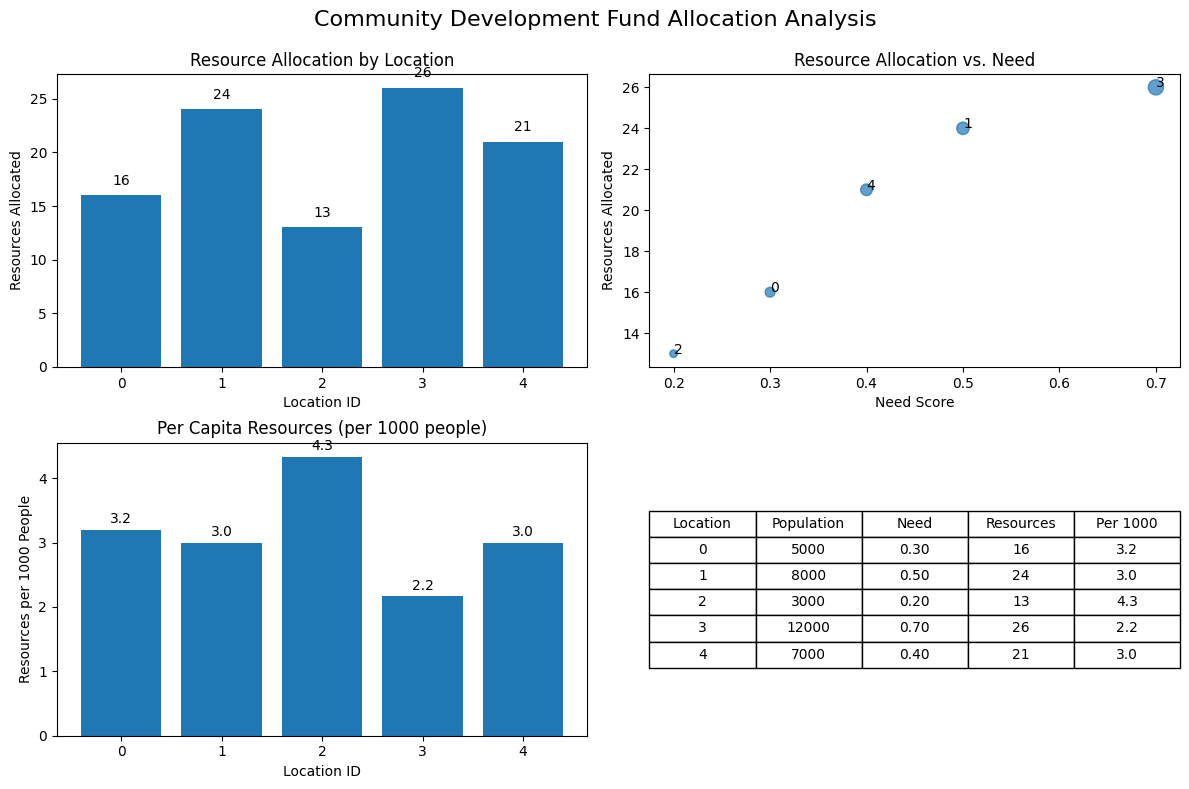


Allocation Summary:
Total Resources Allocated: 100
Correlation with Need Score: 0.9572
Per Capita Range: 2.17 to 4.33


In [11]:
# Run the algorithm and visualize results
def run_allocation_example():
    # Get data
    population, need_scores, distances, total_resources = create_allocation_example()

    # Run allocation algorithm
    allocations = optimal_resource_allocation(total_resources, need_scores, distances)

    # Calculate per capita allocation for analysis
    per_capita = allocations / population * 1000  # Resources per 1000 people

    # Visualize results
    plt.figure(figsize=(12, 8))

    # Plot 1: Allocation by location
    plt.subplot(2, 2, 1)
    plt.bar(range(len(allocations)), allocations)
    plt.title('Resource Allocation by Location')
    plt.xlabel('Location ID')
    plt.ylabel('Resources Allocated')
    plt.xticks(range(len(allocations)))
    for i, v in enumerate(allocations):
        plt.text(i, v+1, str(v), ha='center')

    # Plot 2: Resources vs Need
    plt.subplot(2, 2, 2)
    plt.scatter(need_scores, allocations, s=population/100, alpha=0.7)
    plt.title('Resource Allocation vs. Need')
    plt.xlabel('Need Score')
    plt.ylabel('Resources Allocated')
    for i, txt in enumerate(range(len(allocations))):
        plt.annotate(txt, (need_scores[i], allocations[i]))

    # Plot 3: Per capita resources
    plt.subplot(2, 2, 3)
    plt.bar(range(len(per_capita)), per_capita)
    plt.title('Per Capita Resources (per 1000 people)')
    plt.xlabel('Location ID')
    plt.ylabel('Resources per 1000 People')
    plt.xticks(range(len(per_capita)))
    for i, v in enumerate(per_capita):
        plt.text(i, v+0.1, f"{v:.1f}", ha='center')

    # Plot 4: Table of values
    plt.subplot(2, 2, 4)
    plt.axis('off')
    table_data = [
        ["Location", "Population", "Need", "Resources", "Per 1000"],
    ]
    for i in range(len(allocations)):
        table_data.append([
            f"{i}",
            f"{population[i]}",
            f"{need_scores[i]:.2f}",
            f"{allocations[i]}",
            f"{per_capita[i]:.1f}"
        ])
    table = plt.table(cellText=table_data, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.tight_layout()
    plt.suptitle('Community Development Fund Allocation Analysis', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

    # Print summary statistics
    print("\nAllocation Summary:")
    print(f"Total Resources Allocated: {np.sum(allocations)}")
    print(f"Correlation with Need Score: {np.corrcoef(need_scores, allocations)[0,1]:.4f}")
    print(f"Per Capita Range: {np.min(per_capita):.2f} to {np.max(per_capita):.2f}")

    return allocations, population, need_scores

# Run the example
if __name__ == "__main__":
    allocations, population, need_scores = run_allocation_example()

# Reflection Question 2

**2.1:** According to "Optimal Community Center Locations," areas located roughly between y = 50 to 100 and x = 20 to 60 have lowest population density. Areas between y = 0 to 40 and x = 0 to 40 have the highest population density.

**2.2:** Center 4 serves the most people. Center 0 serves the least. This could matter in policy decisions because the county could prioritize serving the highest number of people, or they could prioritize serving people who may face barriers to accessing services at the larger centers (such as transportation). Under the former, the county may remove or limit the extent of services offered at smaller centers. Under the latter, they may prioritize ensuring that smaller centers are well-resourced.

# Reflection Question 3

**3.1:** Population points in the upper left quadrant of "Optimal Community Center Locations" appear furthest from their assigned center, while points in the lower left quadrant appear closest.

**3.2:** The scattered points surrounding center 0 appear underserved, along with the points found around and between centers 2 and 3. The fact that points are scattered beyond the circles denoting service areas indicates that residents may have to travel significant distances to access a service center.

# Reflection Question 4

**4.1:** Population points in the upper left quadrant of "Optimal Community Center Locations" appear furthest from their assigned center, while points in the lower left quadrant appear closest.

The scattered points surrounding center 0 appear underserved, along with the points found around and between centers 2 and 3. The fact that points are scattered beyond the circles denoting service areas indicates that residents may have to travel significant distances to access a service center.

**4.2:** If we reduce the number of centers from 5 to 3, the centers are placed at roughly:

x = 25, y = 25
x = 40, y = 75
x = 75, y = 50

Center 0 covers the entire area under the lower left quadrant, while disparate points scaterr around center 1 in the middle right, and a small number of even more disparate points roughly surround center 2.

Under this algorithm, the county will see diminishing returns at 6 centers. At 6 centers, only residents in the most populated areas of the county will see decreased travel times. Also, one center will serve only 5 locations, which is not worth the slight decrease in average travel time for communities that would already be close to their service center under a system with 5 centers.

**4.3:** If we removed all population weighting and treated all points equally, resources would be allocated equally across all locations regardless of need, accessibility, or population size. Service center locations would be assigned not based on population density, need, or accessibility, but at the mean of all points assigned to a center. This could make services more efficient by reducing travel times (since centers are evenly distributed across the map), but also less efficient because there are different levels of demand to meet between more or less densely populated areas. Services may be less equitable, as the distribution favors rural residents at the expense of underserving high-population, high-need areas.

# Algorithm 1 with more weight on accessibility

# Algorithm 2 with 3 centers

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def clustering_based_service_locations(coordinates, num_centers, population_weights=None):
    """
    Find optimal service center locations using weighted k-means clustering.

    Args:
        coordinates: Array of coordinates for population points
        num_centers: Number of service centers to place
        population_weights: Weights for each coordinate

    Returns:
        center_locations: Coordinates of the recommended service centers
        assignments: Assigned center for each input coordinate
    """
    print("Starting service location clustering algorithm...")
    n_points = coordinates.shape[0]

    # If no weights provided, use equal weights
    if population_weights is None:
        print("No population weights provided. Using equal weights.")
        population_weights = np.ones(n_points)
    else:
        print(f"Using population weights (min={min(population_weights):.1f}, max={max(population_weights):.1f})")

    # Normalize weights
    weights = population_weights / np.sum(population_weights)

    # Initialize centers randomly
    np.random.seed(42)  # For reproducibility
    idx = np.random.choice(n_points, num_centers, replace=False)
    centers = coordinates[idx].copy()
    print(f"Initialized {num_centers} random center locations")

    # K-means iterations
    max_iterations = 100
    tolerance = 1e-4

    for iteration in range(max_iterations):
        # Calculate distances to centers
        distances = np.zeros((n_points, num_centers))
        for i in range(num_centers):
            distances[:, i] = np.sum((coordinates - centers[i])**2, axis=1)

        # Assign points to nearest center
        assignments = np.argmin(distances, axis=1)

        # Update centers
        new_centers = np.zeros_like(centers)
        for i in range(num_centers):
            mask = (assignments == i)
            if np.sum(mask) > 0:
                # Weighted average of points
                new_centers[i] = np.average(
                    coordinates[mask],
                    axis=0,
                    weights=weights[mask]
                )

        # Check convergence
        center_shift = np.sum((centers - new_centers)**2)
        centers = new_centers

        if center_shift < tolerance:
            print(f"Converged after {iteration+1} iterations")
            break

    print("Service center location optimization complete")
    return centers, assignments

In [18]:
# Create test data for service center placement
def create_clustering_example():
    print("Creating test data for service center placement...")
    # Set random seed for reproducibility
    np.random.seed(42)

    # Create three clusters of population points
    n_points = 100

    # Cluster 1: Dense urban area
    urban_x = np.random.normal(25, 5, size=50)
    urban_y = np.random.normal(25, 5, size=50)
    urban_pop = np.random.normal(1000, 200, size=50)  # Higher population

    # Cluster 2: Suburban area
    suburban_x = np.random.normal(75, 10, size=30)
    suburban_y = np.random.normal(50, 10, size=30)
    suburban_pop = np.random.normal(500, 100, size=30)  # Medium population

    # Cluster 3: Rural area
    rural_x = np.random.normal(40, 15, size=20)
    rural_y = np.random.normal(75, 15, size=20)
    rural_pop = np.random.normal(200, 50, size=20)  # Lower population

    # Combine into single arrays
    x_coords = np.concatenate([urban_x, suburban_x, rural_x])
    y_coords = np.concatenate([urban_y, suburban_y, rural_y])
    population = np.concatenate([urban_pop, suburban_pop, rural_pop])

    # Create coordinates array
    coordinates = np.column_stack([x_coords, y_coords])

    # Number of service centers to place
    num_centers = 3

    print(f"Created {len(coordinates)} population points and will place {num_centers} centers")
    return coordinates, population, num_centers

Creating test data for service center placement...
Created 100 population points and will place 3 centers
Starting service location clustering algorithm...
Using population weights (min=102.4, max=1492.6)
Initialized 3 random center locations
Converged after 7 iterations
Service center location optimization complete

Service Center Statistics:
Center | Population Served | # of Locations | Avg Distance
-------|-------------------|----------------|-------------
      0 |             49886 |               51 |        5.90
      1 |             15358 |               31 |       12.00
      2 |              3670 |               18 |       17.75


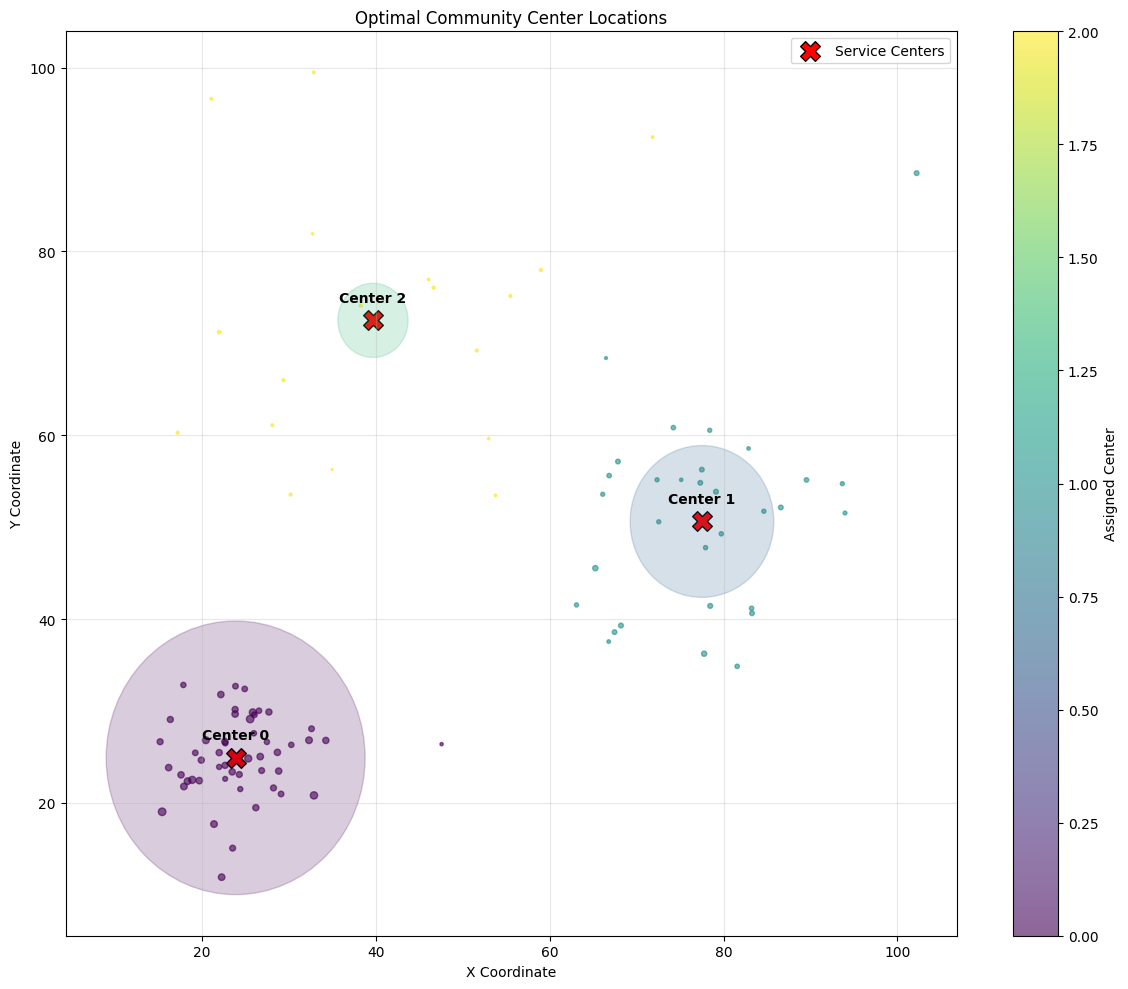

In [19]:
# Run the algorithm and visualize results
def run_clustering_example():
    # Get data
    coordinates, population, num_centers = create_clustering_example()

    # Run clustering algorithm
    centers, assignments = clustering_based_service_locations(coordinates, num_centers, population)

    # Visualize the results
    plt.figure(figsize=(12, 10))

    # Plot population points, sized by population and colored by assigned center
    scatter = plt.scatter(
        coordinates[:, 0], coordinates[:, 1],
        s=population/50,  # Size by population
        c=assignments,    # Color by assignment
        cmap='viridis',
        alpha=0.6
    )

    # Plot service centers
    plt.scatter(
        centers[:, 0], centers[:, 1],
        s=200,
        c='red',
        marker='X',
        edgecolors='black',
        label='Service Centers'
    )

    # Add center labels
    for i, (x, y) in enumerate(centers):
        plt.text(x, y+2, f'Center {i}', ha='center', fontweight='bold')

    # Add a visual representation of population served
    for i in range(num_centers):
        mask = (assignments == i)
        pop_served = np.sum(population[mask])
        # Draw a circle proportional to population served
        pop_radius = np.sqrt(pop_served) / 15
        circle = plt.Circle(
            (centers[i, 0], centers[i, 1]),
            pop_radius,
            color=plt.cm.viridis(i/num_centers),
            alpha=0.2
        )
        plt.gca().add_patch(circle)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Optimal Community Center Locations')
    plt.grid(True, alpha=0.3)
    plt.colorbar(scatter, label='Assigned Center')
    plt.legend()

    # Print statistics for each center
    print("\nService Center Statistics:")
    print("Center | Population Served | # of Locations | Avg Distance")
    print("-------|-------------------|----------------|-------------")

    for i in range(num_centers):
        mask = (assignments == i)
        locations_served = np.sum(mask)
        pop_served = np.sum(population[mask])

        # Calculate average distance to center
        if locations_served > 0:
            center_dists = np.sqrt(np.sum((coordinates[mask] - centers[i])**2, axis=1))
            avg_dist = np.average(center_dists, weights=population[mask])
        else:
            avg_dist = 0

        print(f"{i:7d} | {pop_served:17.0f} | {locations_served:16d} | {avg_dist:11.2f}")

    plt.tight_layout()
    plt.show()

    return centers, assignments, coordinates, population

# Run the example
if __name__ == "__main__":
    centers, assignments, coordinates, population = run_clustering_example()

# Algorithm 2 with 6 centers

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def clustering_based_service_locations(coordinates, num_centers, population_weights=None):
    """
    Find optimal service center locations using weighted k-means clustering.

    Args:
        coordinates: Array of coordinates for population points
        num_centers: Number of service centers to place
        population_weights: Weights for each coordinate

    Returns:
        center_locations: Coordinates of the recommended service centers
        assignments: Assigned center for each input coordinate
    """
    print("Starting service location clustering algorithm...")
    n_points = coordinates.shape[0]

    # If no weights provided, use equal weights
    if population_weights is None:
        print("No population weights provided. Using equal weights.")
        population_weights = np.ones(n_points)
    else:
        print(f"Using population weights (min={min(population_weights):.1f}, max={max(population_weights):.1f})")

    # Normalize weights
    weights = population_weights / np.sum(population_weights)

    # Initialize centers randomly
    np.random.seed(42)  # For reproducibility
    idx = np.random.choice(n_points, num_centers, replace=False)
    centers = coordinates[idx].copy()
    print(f"Initialized {num_centers} random center locations")

    # K-means iterations
    max_iterations = 100
    tolerance = 1e-4

    for iteration in range(max_iterations):
        # Calculate distances to centers
        distances = np.zeros((n_points, num_centers))
        for i in range(num_centers):
            distances[:, i] = np.sum((coordinates - centers[i])**2, axis=1)

        # Assign points to nearest center
        assignments = np.argmin(distances, axis=1)

        # Update centers
        new_centers = np.zeros_like(centers)
        for i in range(num_centers):
            mask = (assignments == i)
            if np.sum(mask) > 0:
                # Weighted average of points
                new_centers[i] = np.average(
                    coordinates[mask],
                    axis=0,
                    weights=weights[mask]
                )

        # Check convergence
        center_shift = np.sum((centers - new_centers)**2)
        centers = new_centers

        if center_shift < tolerance:
            print(f"Converged after {iteration+1} iterations")
            break

    print("Service center location optimization complete")
    return centers, assignments

In [25]:
# Create test data for service center placement
def create_clustering_example():
    print("Creating test data for service center placement...")
    # Set random seed for reproducibility
    np.random.seed(42)

    # Create three clusters of population points
    n_points = 100

    # Cluster 1: Dense urban area
    urban_x = np.random.normal(25, 5, size=50)
    urban_y = np.random.normal(25, 5, size=50)
    urban_pop = np.random.normal(1000, 200, size=50)  # Higher population

    # Cluster 2: Suburban area
    suburban_x = np.random.normal(75, 10, size=30)
    suburban_y = np.random.normal(50, 10, size=30)
    suburban_pop = np.random.normal(500, 100, size=30)  # Medium population

    # Cluster 3: Rural area
    rural_x = np.random.normal(40, 15, size=20)
    rural_y = np.random.normal(75, 15, size=20)
    rural_pop = np.random.normal(200, 50, size=20)  # Lower population

    # Combine into single arrays
    x_coords = np.concatenate([urban_x, suburban_x, rural_x])
    y_coords = np.concatenate([urban_y, suburban_y, rural_y])
    population = np.concatenate([urban_pop, suburban_pop, rural_pop])

    # Create coordinates array
    coordinates = np.column_stack([x_coords, y_coords])

    # Number of service centers to place
    num_centers = 6

    print(f"Created {len(coordinates)} population points and will place {num_centers} centers")
    return coordinates, population, num_centers

Creating test data for service center placement...
Created 100 population points and will place 7 centers
Starting service location clustering algorithm...
Using population weights (min=102.4, max=1492.6)
Initialized 7 random center locations
Converged after 7 iterations
Service center location optimization complete

Service Center Statistics:
Center | Population Served | # of Locations | Avg Distance
-------|-------------------|----------------|-------------
      0 |              3324 |               16 |       16.40
      1 |              6606 |               15 |       11.38
      2 |              9098 |               18 |        9.70
      3 |              3173 |                3 |        2.47
      4 |             15672 |               15 |        3.25
      5 |             15506 |               17 |        3.80
      6 |             15535 |               16 |        3.29


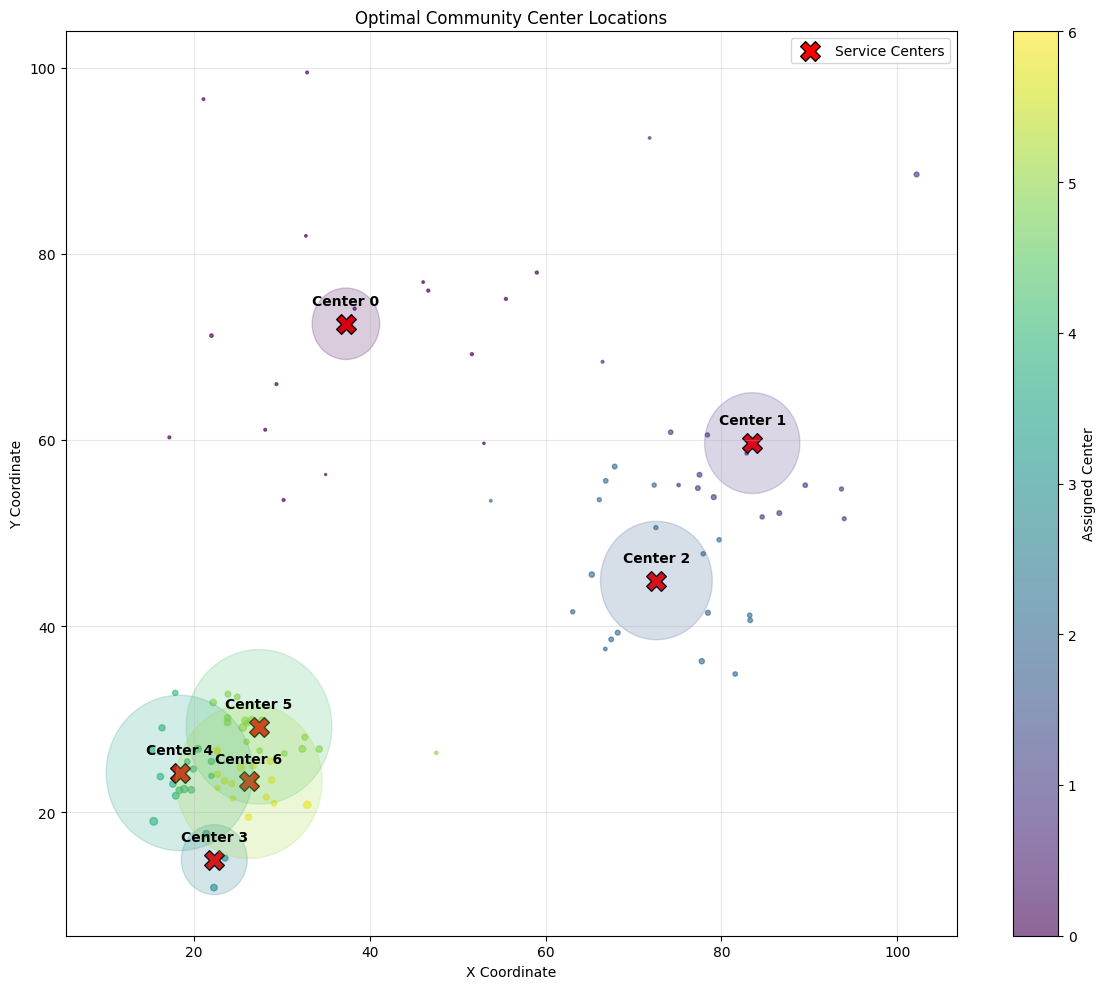

In [24]:
# Run the algorithm and visualize results
def run_clustering_example():
    # Get data
    coordinates, population, num_centers = create_clustering_example()

    # Run clustering algorithm
    centers, assignments = clustering_based_service_locations(coordinates, num_centers, population)

    # Visualize the results
    plt.figure(figsize=(12, 10))

    # Plot population points, sized by population and colored by assigned center
    scatter = plt.scatter(
        coordinates[:, 0], coordinates[:, 1],
        s=population/50,  # Size by population
        c=assignments,    # Color by assignment
        cmap='viridis',
        alpha=0.6
    )

    # Plot service centers
    plt.scatter(
        centers[:, 0], centers[:, 1],
        s=200,
        c='red',
        marker='X',
        edgecolors='black',
        label='Service Centers'
    )

    # Add center labels
    for i, (x, y) in enumerate(centers):
        plt.text(x, y+2, f'Center {i}', ha='center', fontweight='bold')

    # Add a visual representation of population served
    for i in range(num_centers):
        mask = (assignments == i)
        pop_served = np.sum(population[mask])
        # Draw a circle proportional to population served
        pop_radius = np.sqrt(pop_served) / 15
        circle = plt.Circle(
            (centers[i, 0], centers[i, 1]),
            pop_radius,
            color=plt.cm.viridis(i/num_centers),
            alpha=0.2
        )
        plt.gca().add_patch(circle)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Optimal Community Center Locations')
    plt.grid(True, alpha=0.3)
    plt.colorbar(scatter, label='Assigned Center')
    plt.legend()

    # Print statistics for each center
    print("\nService Center Statistics:")
    print("Center | Population Served | # of Locations | Avg Distance")
    print("-------|-------------------|----------------|-------------")

    for i in range(num_centers):
        mask = (assignments == i)
        locations_served = np.sum(mask)
        pop_served = np.sum(population[mask])

        # Calculate average distance to center
        if locations_served > 0:
            center_dists = np.sqrt(np.sum((coordinates[mask] - centers[i])**2, axis=1))
            avg_dist = np.average(center_dists, weights=population[mask])
        else:
            avg_dist = 0

        print(f"{i:7d} | {pop_served:17.0f} | {locations_served:16d} | {avg_dist:11.2f}")

    plt.tight_layout()
    plt.show()

    return centers, assignments, coordinates, population

# Run the example
if __name__ == "__main__":
    centers, assignments, coordinates, population = run_clustering_example()

# Algorithm 1 with no population weighting


In [30]:
import numpy as np  # Mathematical operations library
import matplotlib.pyplot as plt  # Data visualization library

def optimal_resource_allocation(resources, n_locations):
    """
    Distribute resources equally across all locations, ignoring need or accessibility.

    Args:
        resources: Total resources available to distribute
        n_locations: Number of locations

    Returns:
        allocations: Equal distribution of resources across locations
    """
    print("Removing population weighting...")

    # Allocate resources equally across locations
    allocations = np.full(n_locations, resources / n_locations)

    print(f"Resources allocated equally: {allocations}")
    return np.round(allocations)

In [31]:
# Create test data for resource allocation
def create_allocation_example():
    print("Creating test data for resource allocation...")
    n_locations = 5  # Number of locations

    # Need score (e.g., poverty rate from 0-1, but no longer used for weighting)
    need_scores = np.array([0.3, 0.5, 0.2, 0.7, 0.4])

    # Total resources to allocate
    total_resources = 100

    print(f"Created data for {n_locations} locations with ${total_resources} to allocate")
    return need_scores, total_resources

Creating test data for resource allocation...
Created data for 5 locations with $100 to allocate
Removing population weighting...
Resources allocated equally: [20. 20. 20. 20. 20.]


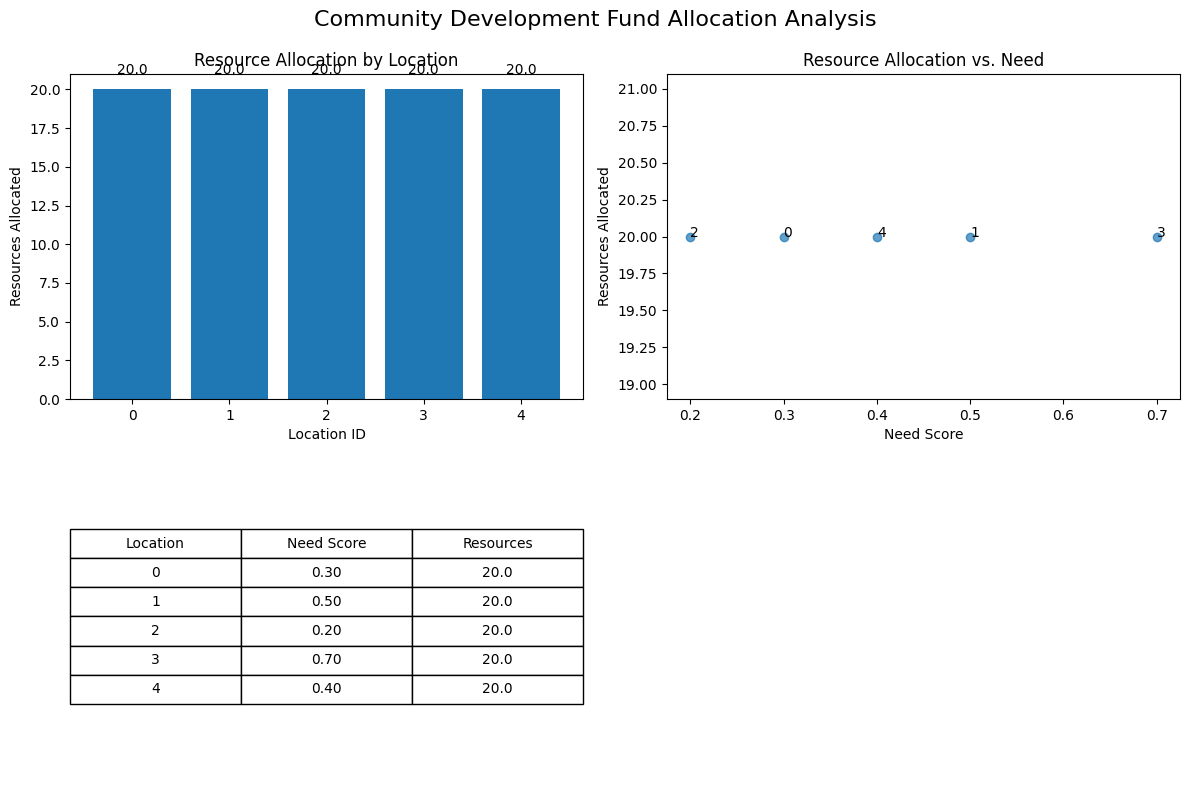


Allocation Summary:
Total Resources Allocated: 100.0


In [32]:
# Run the algorithm and visualize results
def run_allocation_example():
    # Get data
    need_scores, total_resources = create_allocation_example()

    # Run allocation algorithm
    allocations = optimal_resource_allocation(total_resources, len(need_scores))

    # Visualize results
    plt.figure(figsize=(12, 8))

    # Plot 1: Allocation by location
    plt.subplot(2, 2, 1)
    plt.bar(range(len(allocations)), allocations)
    plt.title('Resource Allocation by Location')
    plt.xlabel('Location ID')
    plt.ylabel('Resources Allocated')
    plt.xticks(range(len(allocations)))
    for i, v in enumerate(allocations):
        plt.text(i, v+1, str(v), ha='center')

    # Plot 2: Resources vs Need
    plt.subplot(2, 2, 2)
    plt.scatter(need_scores, allocations, alpha=0.7)
    plt.title('Resource Allocation vs. Need')
    plt.xlabel('Need Score')
    plt.ylabel('Resources Allocated')
    for i, txt in enumerate(range(len(allocations))):
        plt.annotate(txt, (need_scores[i], allocations[i]))

    # Plot 3: Table of values
    plt.subplot(2, 2, 3)
    plt.axis('off')
    table_data = [
        ["Location", "Need Score", "Resources"],
    ]
    for i in range(len(allocations)):
        table_data.append([
            f"{i}",
            f"{need_scores[i]:.2f}",
            f"{allocations[i]}"
        ])
    table = plt.table(cellText=table_data, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.tight_layout()
    plt.suptitle('Community Development Fund Allocation Analysis', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

    # Print summary statistics
    print("\nAllocation Summary:")
    print(f"Total Resources Allocated: {np.sum(allocations)}")

    return allocations, need_scores

# Run the example
if __name__ == "__main__":
    allocations, need_scores = run_allocation_example()

# Algorithm 2 with no population weighting

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def clustering_based_service_locations(coordinates, num_centers):
    """
    Find optimal service center locations using k-means clustering without population weighting.

    Args:
        coordinates: Array of coordinates for population points
        num_centers: Number of service centers to place

    Returns:
        center_locations: Coordinates of the recommended service centers
        assignments: Assigned center for each input coordinate
    """
    print("Starting service location clustering algorithm...")
    n_points = coordinates.shape[0]

    # Initialize centers randomly
    np.random.seed(42)  # For reproducibility
    idx = np.random.choice(n_points, num_centers, replace=False)
    centers = coordinates[idx].copy()
    print(f"Initialized {num_centers} random center locations")

    # K-means iterations
    max_iterations = 100
    tolerance = 1e-4

    for iteration in range(max_iterations):
        # Calculate distances to centers
        distances = np.zeros((n_points, num_centers))
        for i in range(num_centers):
            distances[:, i] = np.sum((coordinates - centers[i])**2, axis=1)

        # Assign points to nearest center
        assignments = np.argmin(distances, axis=1)

        # Update centers
        new_centers = np.zeros_like(centers)
        for i in range(num_centers):
            mask = (assignments == i)
            if np.sum(mask) > 0:
                # Simple average of points (no population weighting)
                new_centers[i] = np.mean(coordinates[mask], axis=0)

        # Check convergence
        center_shift = np.sum((centers - new_centers)**2)
        centers = new_centers

        if center_shift < tolerance:
            print(f"Converged after {iteration+1} iterations")
            break

    print("Service center location optimization complete")
    return centers, assignments

In [47]:
# Create test data for service center placement
def create_clustering_example():
    print("Creating test data for service center placement...")

    # Set random seed for reproducibility
    np.random.seed(42)

    # Create three clusters of population points
    n_points = 100

    # Cluster 1: Dense urban area
    urban_x = np.random.normal(25, 5, size=50)
    urban_y = np.random.normal(25, 5, size=50)

    # Cluster 2: Suburban area
    suburban_x = np.random.normal(75, 10, size=30)
    suburban_y = np.random.normal(50, 10, size=30)

    # Cluster 3: Rural area
    rural_x = np.random.normal(40, 15, size=20)
    rural_y = np.random.normal(75, 15, size=20)

    # Combine into single arrays
    x_coords = np.concatenate([urban_x, suburban_x, rural_x])
    y_coords = np.concatenate([urban_y, suburban_y, rural_y])
    coordinates = np.column_stack([x_coords, y_coords])

    num_centers = 5
    print(f"Created {len(coordinates)} population points and will place {num_centers} centers")
    return coordinates, num_centers

Creating test data for service center placement...
Created 100 population points and will place 5 centers
Starting service location clustering algorithm...
Initialized 5 random center locations
Converged after 3 iterations
Service center location optimization complete

Service Center Statistics:
Center | # of Locations | Avg Distance
-------|----------------|-------------
      0 |               14 |       13.04
      1 |               16 |       11.76
      2 |               20 |       10.97
      3 |               19 |        4.70
      4 |               31 |        4.65


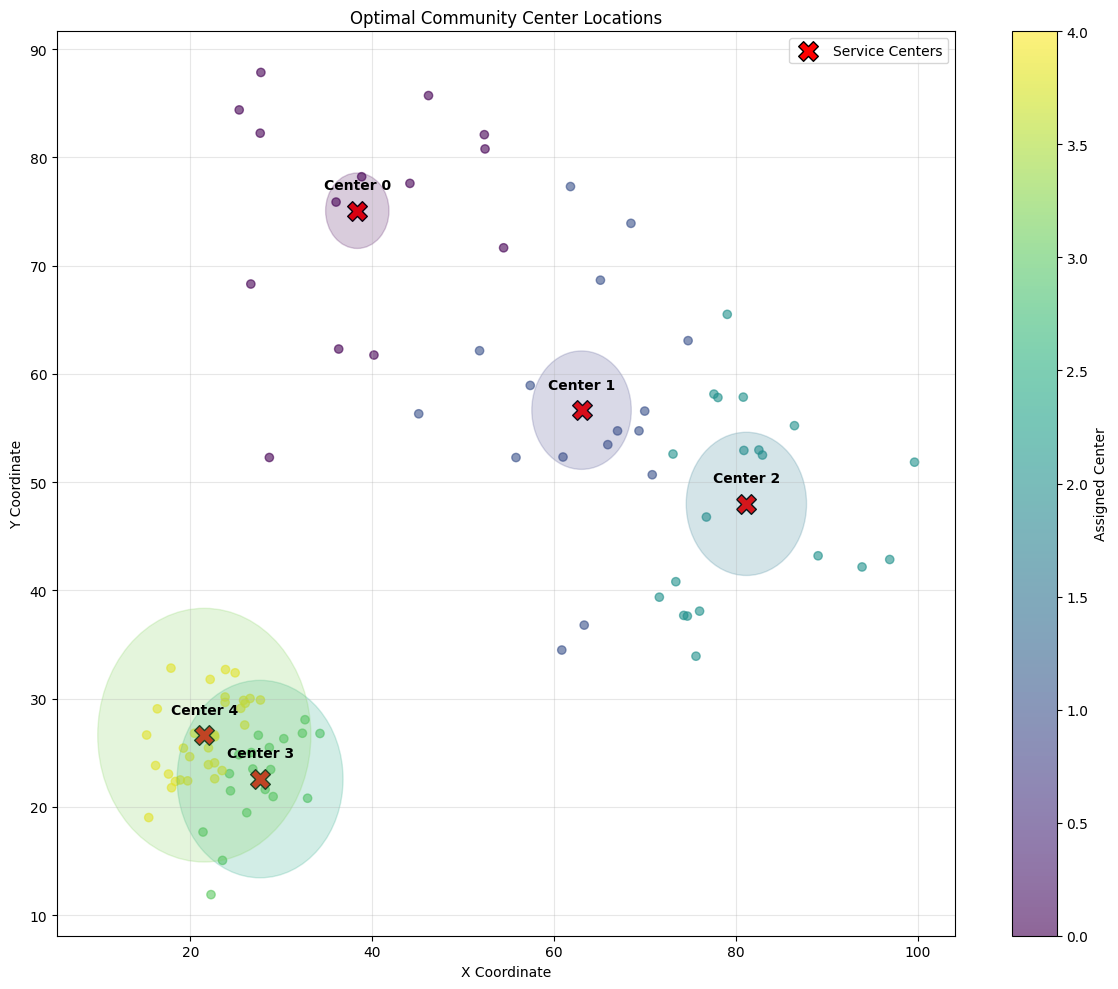

In [60]:
# Run the algorithm and visualize results
def run_clustering_example():
    # Get data
    coordinates, num_centers = create_clustering_example()
    centers, assignments = clustering_based_service_locations(coordinates, num_centers)

    # Run clustering algorithm
    plt.figure(figsize=(12, 10))

    # Visualize the results
    scatter = plt.scatter(
        coordinates[:, 0], coordinates[:, 1],
        c=assignments,    # Color by assignment
        cmap='viridis',
        alpha=0.6
    )

    # Plot service centers
    plt.scatter(
        centers[:, 0], centers[:, 1],
        s=200,
        c='red',
        marker='X',
        edgecolors='black',
        label='Service Centers'
    )

    # Add center labels
    for i, (x, y) in enumerate(centers):
        plt.text(x, y+2, f'Center {i}', ha='center', fontweight='bold')

    # Add a visual representation of population served
    for i in range(num_centers):
        mask = (assignments == i)
        pop_served = np.sum(population[mask])
        # Draw a circle proportional to population served
        pop_radius = np.sqrt(pop_served) / 15
        circle = plt.Circle(
            (centers[i, 0], centers[i, 1]),
            pop_radius,
            color=plt.cm.viridis(i/num_centers),
            alpha=0.2
        )
        plt.gca().add_patch(circle)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Optimal Community Center Locations')
    plt.grid(True, alpha=0.3)
    plt.colorbar(scatter, label='Assigned Center')
    plt.legend()

    # Print statistics for each center
    print("\nService Center Statistics:")
    print("Center | # of Locations | Avg Distance")
    print("-------|----------------|-------------")

    for i in range(num_centers):
        mask = (assignments == i)
        locations_served = np.sum(mask)

        # Calculate average distance to center
        if locations_served > 0:
            center_dists = np.sqrt(np.sum((coordinates[mask] - centers[i])**2, axis=1))
            avg_dist = np.mean(center_dists)
        else:
            avg_dist = 0

        print(f"{i:7d} | {locations_served:16d} | {avg_dist:11.2f}")

    plt.tight_layout()
    plt.show()

    return centers, assignments, coordinates

# Run the example
if __name__ == "__main__":
    centers, assignments, coordinates = run_clustering_example()